## Import library

In [1]:
import os
import glob
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torchview import draw_graph

In [2]:
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Config

In [3]:
class cfg: 

    #====================
    # Data ROOT
    DATA_ROOT = os.path.join("..", "..", "..", 
                             "data", 
                             "faces",)
    

## Utility Functions

### imshow()

In [4]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    


     

### show_plot()

In [5]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### SiameseNetworkDataset()

In [6]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,
                 imageFolderDataset,
                 transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

    
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    


### ContrastiveLoss()

In [7]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

## Understanding layers

### F.pairwise_distance()

**p=2; means L2 norm; Euclidian distances**

In [8]:
tensor1 = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
tensor2 = torch.tensor([[1.0, 3.0], [4.0, 4.0], [6.0, 5.0]])

# Calculate pairwise distances using L2 norm
distances = F.pairwise_distance(tensor1, tensor2, p=2)
print(distances)

tensor([1.0000, 1.0000, 1.4142])


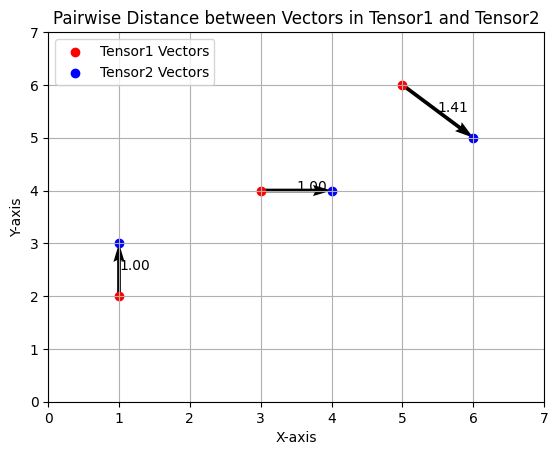

In [9]:
# Plotting the vectors and distances
fig, ax = plt.subplots()
ax.quiver(tensor1[:, 0], tensor1[:, 1], tensor2[:, 0] - tensor1[:, 0], tensor2[:, 1] - tensor1[:, 1],
          angles='xy', scale_units='xy', scale=1, color='k', linestyle='dashed')

ax.scatter(tensor1[:, 0], tensor1[:, 1], color='r', label='Tensor1 Vectors')
ax.scatter(tensor2[:, 0], tensor2[:, 1], color='b', label='Tensor2 Vectors')

for i in range(tensor1.shape[0]):
    ax.text((tensor1[i, 0] + tensor2[i, 0]) / 2, 
            (tensor1[i, 1] + tensor2[i, 1]) / 2, 
            f'{distances[i]:.2f}', color='black'
           )

ax.set_xlim(0, 7)
ax.set_ylim(0, 7)
ax.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Pairwise Distance between Vectors in Tensor1 and Tensor2')
plt.grid()
plt.show()

### Contrastive loss Concept

Contrastive loss is a loss function used primarily in tasks involving similarity learning, such as face verification, image retrieval, and other tasks that require learning to distinguish between similar and dissimilar pairs of data points. It is often employed in training Siamese Networks and other types of deep learning models designed to learn embeddings or feature representations.

**Concept and Formula**

The contrastive loss function is designed to minimize the distance between similar pairs and maximize the distance between dissimilar pairs. The loss function can be defined as follows:

Given a pair of data points $(x_1, x_2)$:
- $D_W(x_1, x_2)$ represents the distance between the embeddings of $x_1$ and $x_2$, typically using Euclidean distance.
- $y$ is a binary label indicating whether $x_1$ and $x_2$ are similar $y = 0$ or dissimilar $y = 1$.
- $m$ is a margin parameter that defines the minimum distance between dissimilar pairs.

The contrastive loss \(L\) is given by:
$$ L = (1 - y) \cdot \frac{1}{2} D_W(x_1, x_2)^2 + y \cdot \frac{1}{2} \max(0, m - D_W(x_1, x_2))^2 $$

**Explanation:**
1. **Similar Pairs $(y = 0)$**: For similar pairs, the goal is to minimize the distance $D_W(x_1, x_2)$. The loss term $(1 - y) \cdot \frac{1}{2} D_W(x_1, x_2)^2$ achieves this by penalizing large distances.
2. **Dissimilar Pairs $(y = 1)$**: For dissimilar pairs, the goal is to ensure that the distance $D_W(x_1, x_2)$ is at least $m$. The loss term $y \cdot \frac{1}{2} \max(0, m - D_W(x_1, x_2))^2$ achieves this by penalizing distances smaller than $m$.

**Applications**
- **Face Verification**: To determine whether two face images belong to the same person.
- **Image Retrieval**: To retrieve similar images from a database.
- **Signature Verification**: To verify whether two signatures are from the same person.

**Key Points:**
- **Optimization Objective**: Contrastive loss optimizes the model to learn a feature space where similar data points are closer together and dissimilar data points are farther apart.
- **Margin Parameter**: The margin parameter \(m\) ensures that dissimilar pairs are separated by at least a certain distance.

Contrastive loss is a powerful tool in deep learning, especially for tasks requiring precise differentiation between similar and dissimilar items, making it invaluable in areas like facial recognition and image retrieval.

# Creating metadata

In [10]:
testing_files_paths = glob.glob(os.path.join(cfg.DATA_ROOT, "testing","*", "*", ))
train_files_paths = glob.glob(os.path.join(cfg.DATA_ROOT, "training","*", "*", ))
all_files_samples = train_files_paths + testing_files_paths

meta_lst = []
for p in all_files_samples: 
    
    lst_fldrs_name = os.path.join(p).split(os.sep)

    fname = lst_fldrs_name[-1]
    sID = lst_fldrs_name[-2]
    split = lst_fldrs_name[-3]

    meta_lst.append([p, sID, split, fname])

c = ["path", "sID", "split", "fname"]  
d_meta = pd.DataFrame(meta_lst, columns=c)
d_meta

,path,sID,split,fname
0,..\..\..\data\faces\training\s1\1.pgm,s1,training,1.pgm
1,..\..\..\data\faces\training\s1\10.pgm,s1,training,10.pgm
2,..\..\..\data\faces\training\s1\2.pgm,s1,training,2.pgm
3,..\..\..\data\faces\training\s1\3.pgm,s1,training,3.pgm
4,..\..\..\data\faces\training\s1\4.pgm,s1,training,4.pgm
...,...,...,...,...
395,..\..\..\data\faces\testing\s7\5.pgm,s7,testing,5.pgm
396,..\..\..\data\faces\testing\s7\6.pgm,s7,testing,6.pgm
397,..\..\..\data\faces\testing\s7\7.pgm,s7,testing,7.pgm
398,..\..\..\data\faces\testing\s7\8.pgm,s7,testing,8.pgm


In [11]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root=os.path.join(cfg.DATA_ROOT, "training", ))
folder_dataset 

Dataset ImageFolder
    Number of datapoints: 370
    Root location: ..\..\..\data\faces\training

In [12]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

In [13]:
# Initialize Pythorch Custom dataset
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

In [14]:
img0, img1, img_arr = next(iter(siamese_dataset))
img0.shape, img1.shape, img_arr

(torch.Size([1, 100, 100]), torch.Size([1, 100, 100]), tensor([0.]))

In [15]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            # num_workers=2,
                            batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))
example_batch[0].shape, example_batch[1].shape, example_batch[2].shape # img0, img1, label similar [0,1]

(torch.Size([8, 1, 100, 100]),
 torch.Size([8, 1, 100, 100]),
 torch.Size([8, 1]))

In [16]:
# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
concatenated.shape

torch.Size([16, 1, 100, 100])

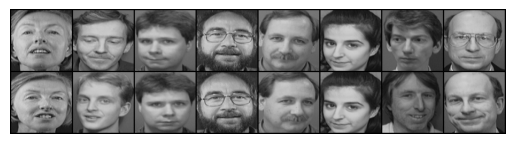

[0. 1. 0. 0. 0. 0. 1. 0.]
If the label is 1, it means that it is not the same person, label is 0, same person in both images


In [17]:

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))
print("If the label is 1, it means that it is not the same person, label is 0, same person in both images")

## SiameseNetwork()

In [18]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11,stride=4),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=3, stride=2),
                                  nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3,stride=1),
                                  nn.ReLU(inplace=True),
                                 )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(nn.Linear(in_features=384, out_features=1024),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(in_features=1024, out_features=256),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(in_features=256,out_features=2),
                                )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [19]:
net = SiameseNetwork().to(device)

In [20]:
# ================================================
# Viz using torchview - GRAPH
model_graph = draw_graph(model=net, 
                         input_size=((1, 1,100,100), (1, 1,100,100))
                         # device='meta',
                        )

In [21]:
model_graph.resize_graph(scale=5.0) # Reduce image size


(dot.exe:6852): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


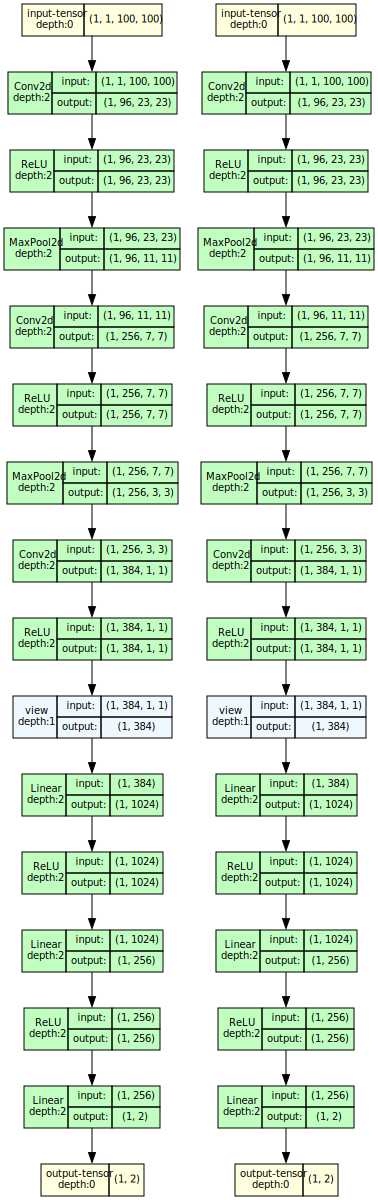

In [22]:
model_graph.visual_graph # viz inline

In [23]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              # num_workers=8,
                              batch_size=64
                             )

In [24]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [25]:

counter = []
loss_history = [] 
iteration_number= 0
# train_dataloader
# criterion

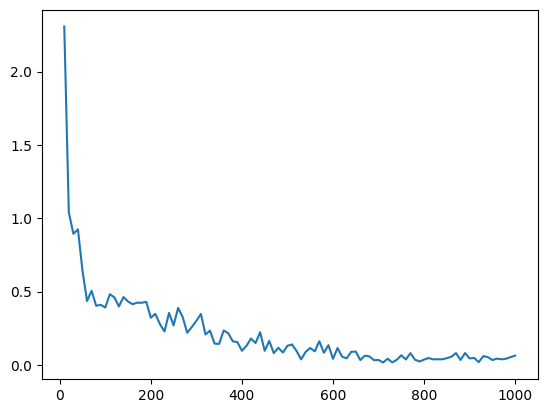

In [26]:

counter = []
loss_history = [] 
iteration_number= 0
out1_lst = []
out2_lst = []

# Iterate throught the epochs
for epoch in range(100):
    
    
    for batch, (img0, img1, label) in enumerate(train_dataloader, 0):
    
        # Send the images and labels to CUDA
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
    
        
        # 1. Forward pass
        output1, output2 = net(img0, img1)
    
        # 2. Calculate  and accumulate loss
        loss_contrastive = criterion(output1, output2, label)
    
        # 3. Optimizer zero grad
        optimizer.zero_grad()
    
        # 4. Loss backward
        loss_contrastive.backward()
    
        # 5. Optimizer step
        optimizer.step()
    
    
        # #___________________
        # # Store
        # out1_lst+= output1.cpu().detach().tolist()
        # out2_lst+= output2.cpu().detach().tolist()
        # loss_history.append(loss_contrastive.item())
    
        # Every 10 batches print out the loss
        if batch % 20 == 0 :
            # print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10
    
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
        

    # break
show_plot(counter, loss_history)
     

In [27]:
# plt.plot(loss_history);

## Testing dataset

In [28]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root=os.path.join(cfg.DATA_ROOT, "testing", ))
folder_dataset 

Dataset ImageFolder
    Number of datapoints: 30
    Root location: ..\..\..\data\faces\testing

In [29]:
# Initialize Pythorch Custom dataset
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

In [30]:
test_dataloader = DataLoader(siamese_dataset, 
                             # num_workers=2, 
                             batch_size=1, 
                             shuffle=True, 
                            )

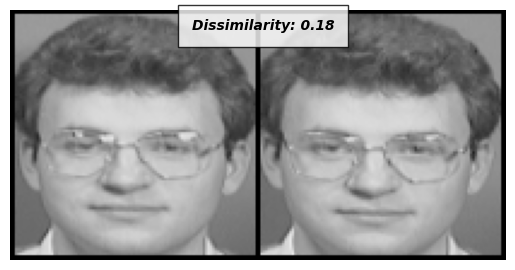

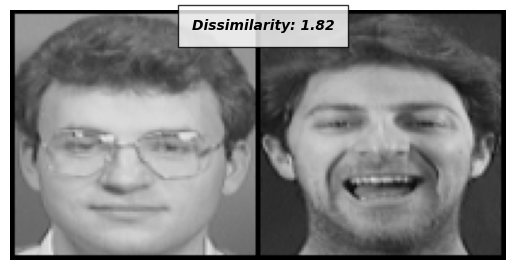

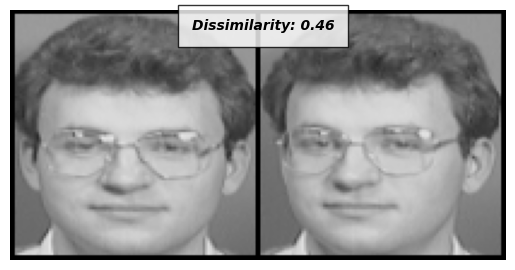

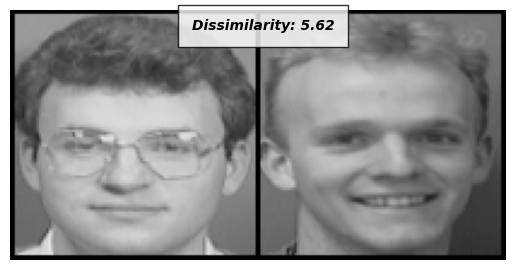

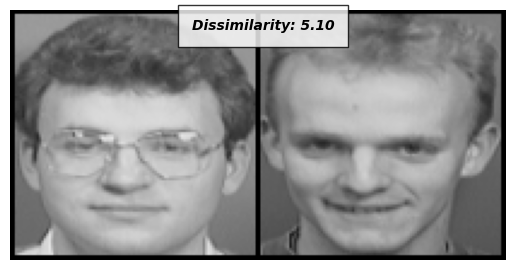

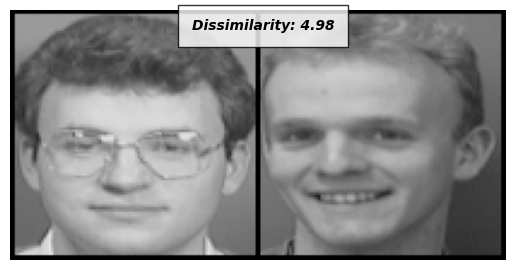

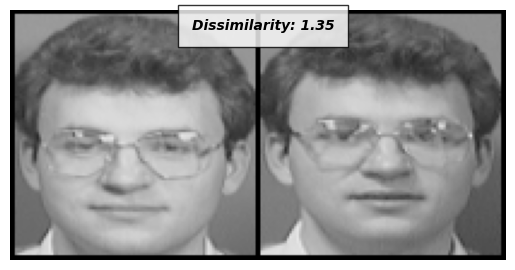

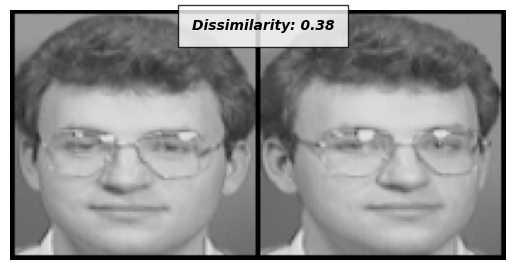

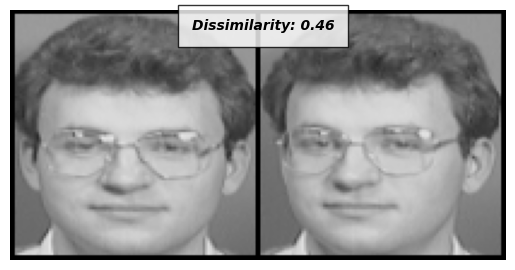

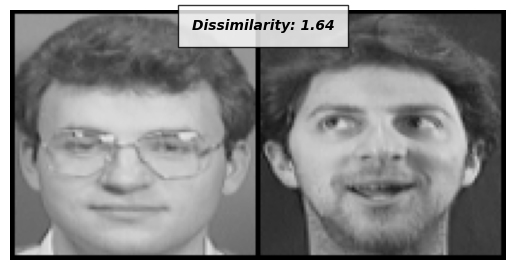

In [31]:
# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [32]:
#===================================================
# Free memory
net.cpu()
del net
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0